# Twitter Sentiment Analysis

In [1]:
# Importing basic libraries
import pandas as pd
import numpy as np
import time as t
from configparser import ConfigParser
config = ConfigParser()

# Plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(12,10)})
# sns.set_style('white')
plt.style.use('fivethirtyeight')

from tqdm import tqdm
tqdm.pandas()

 

/Applications/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
import mysql.connector

In [26]:
import pandas as pd
import re
from tqdm import tqdm
import string
import time
tqdm.pandas()


# Cleaning text helper function
def text_cleaning(text):
    '''
    Clean the text by removing unwanted characters and noise.

    Parameters
    ----------
    text: the text to be cleaned

    return
    ----------
    Cleaned text
    '''
    # checking if text empty
    if (not re.search('[a-zA-Z0-9]', text)) or (type(text) != str) or (text == 'nan'):
        return ''
    text = re.sub(r'@', '', text)             # Remove @ mentions
    text = re.sub(r'#', '', text)              # Remove Hastags symbols
    text = re.sub(r'RT[\s]+', '', text)        # Remove RT mention
    text = re.sub(r'\n', ' ', text)              # Remove line terminator character
    text = re.sub(r'(pictwitter)\w+', '', text)     # Removing picture names
    text = re.sub(r'\xa0', ' ', text)               # Removing non breaking space character
    return text


def url_detect(text):
    '''
    Detect the number of url links in the text

    Parameters
    ----------
    text: the text in which url should be detected

    return
    ---------
    number of url links in the text
    '''
    list_url = re.findall(r'https?:\/\/.*', text)
    return len(list_url)


def url_only(text):
    '''
    Detect if the text is an url only (does not contain anything but an URL link)

    Parameters
    -----------
    text: the text to be evaluated

    return
    ---------
    True or false
    '''
    if re.search(r'^https?:\/\/.*$', text):
        return True
    return False


def preprocess_twitter(data, likes_threshold=5, retweets_threshold=5, scam_dict='Scam_keywords.txt'):
    '''
    Clean the twitter data by removing scams and preparing proper text for sentiment analysis.
    The dataframe must have the following column names:
    - date
    - username
    - text
    - hashtags
    - mentions
    - retweets
    - favorites
    Any other column will be deleted.

    Parameters
    -------------
    data: the dataframe containing tweets.
    likes_threshold: the number of likes threshold below which url tweet are considered as ad
    retweets_threshold: the number of retweets threshold below which url tweet are considered as ad
    scam_dict: the text file used to target scam keywords

    return
    ---------
    Cleaned twitter pandas Dataframe

    '''
    data.loc[:, 'date'] = pd.to_datetime(data.date)
    data = data[['username', 'date', 'hashtags', 'mentions', 'retweets', 'favorites', 'text']].copy()
    real_data = data.dropna(subset=['text']).copy()

    print('Detecting scam tweets...')
    time.sleep(1)
    real_data.loc[:, 'url'] = real_data.text.progress_apply(url_detect)

    with open(scam_dict, 'r') as file:
        content = file.readlines()
    scam_dictionary = [re.sub('\n', '', x.strip().lower()) for x in content]

    # Detect spam helper function
    def scam_detect(text):
        if any([re.search(f'[{string.punctuation} ]{word}[{string.punctuation} ]', text.lower()) for word in scam_dictionary]):
            return True
        if not re.search(' [a-zA-Z]+ ', text):
            return True

    mask1 = real_data.url > 0
    mask2 = real_data.favorites <= likes_threshold
    mask3 = real_data.retweets <= retweets_threshold
    mask4 = real_data.text.progress_apply(scam_detect)
    ads_data = real_data[mask1 & mask2 & mask3 | mask4].drop('url', axis=1)
    no_ads_data = real_data.drop(labels=ads_data.index).drop('url', axis=1)
    try:
        print(f"Remaining data: {round(100 * len(no_ads_data) / len(data))} %\n")
    except:
        pass

    print('Cleaning text...')
    time.sleep(1)
    no_ads_data.loc[:, 'text'] = no_ads_data.text.progress_apply(text_cleaning)

    no_ads_data.loc[:, 'day'] = no_ads_data.date.apply(lambda x: x.date())
    no_ads_data = no_ads_data[['username', 'date', 'day', 'hashtags', 'mentions', 'retweets', 'favorites', 'text']]
    print('Done.')

    return no_ads_data


def preprocess_telegram(data):
    '''
    Clean the telegram data by removing url only messages and preparing proper text for sentiment analysis.
    The dataframe must have the following column names:
    - message id
    - author
    - date
    - message
    Any other column will be deleted.

    Parameters
    -------------
    data: the dataframe containing telegram messages.
    scam_dict: the text file used to target scam keywords

    return
    ---------
    Cleaned telegram pandas Dataframe

    '''
    data.loc[:, 'date'] = pd.to_datetime(data.date)
    real_data = data.dropna(subset=['message']).copy()

    print('Detecting url only messages...')
    time.sleep(1)
    real_data.loc[:, 'url_only'] = real_data.message.progress_apply(url_only)

    mask1 = real_data.url_only == True
    ads_data = real_data[mask1].drop('url_only', axis=1)
    no_ads_data = real_data.drop(labels=ads_data.index).drop('url_only', axis=1)

    print('Cleaning text...')
    time.sleep(1)
    no_ads_data.loc[:, 'text'] = no_ads_data.message.progress_apply(text_cleaning)
    no_ads_data = no_ads_data.drop('message', axis=1)
    no_ads_data.loc[:, 'day'] = no_ads_data.date.apply(lambda x: x.date())
    no_ads_data = no_ads_data[no_ads_data.text != '']

    try:
        print(f"Remaining data: {round(100 * len(no_ads_data) / len(data))} %\n")
    except:
        pass
    print('Done.')

    return no_ads_data


/Applications/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
# Importing and Processing twitter data
####################################################
filename =  "../../Data/Unprocessed_data/DIA_56600.csv"
coin_symbol = "ETH"
####################################################

data = pd.read_csv(filename)
data = preprocess_twitter(data, scam_dict='Scam_keywords.txt').copy()

Detecting scam tweets...


100%|██████████| 56600/56600 [01:00<00:00, 942.36it/s] 


Remaining data: 75 %

Cleaning text...


100%|██████████| 42242/42242 [00:02<00:00, 19058.23it/s]


Done.


In [5]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/scorpion/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
 data.head(5)

,username,date,day,hashtags,mentions,retweets,favorites,text
0,BullCryptochain,2020-08-19 23:55:16+00:00,2020-08-19,NaN,NaN,0,3,$DIA is the way to go
1,catchthenextone,2020-08-19 23:51:58+00:00,2020-08-19,NaN,NaN,0,0,$SPY $DIA $QQQ good to see small caps(tech&amp...
2,diaboro_bit,2020-08-19 23:49:55+00:00,2020-08-19,#bitcoin #bitcoin #kucoin #Binance #Binance,NaN,0,1,He's not serious yet chance near you $DIA bitc...
3,androsForm,2020-08-19 23:39:57+00:00,2020-08-19,NaN,NaN,5,3,$DIA $SPY $IEF “Secular uptrend underway for e...
4,TrifectaAnlysis,2020-08-19 23:37:59+00:00,2020-08-19,NaN,NaN,0,0,$SPX Market internals continue to show weakeni...


In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
from textblob import TextBlob
import time as t
from configparser import ConfigParser
import pandas as pd
import numpy as np
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (12, 10)})
# sns.set_style('white')
plt.style.use('fivethirtyeight')

# Plotting libraries
from tqdm import tqdm
tqdm.pandas()


# Building the sentiment analysis functions
def get_senti(score):
    '''
    Classify the sentiment category based on polarity score

    Parameters
    ----------
    score: polarity score

    Return
    -------
    Sentiment category (str)
    '''
    if score < -0.5:
        return 'very negative'
    elif score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    elif score < 0.5:
        return 'positive'
    else:
        return 'very positive'


def blob_sentiment(dataframe, col_text='text'):
    '''
    Compute the sentiment of all rows in a Dataframe using TextBlob.

    Parameters
    -----------
    dataframe: the dataframe containing textual information
    col_text: the name of the column which contains the text to be analyzed

    Return
    ----------
    A new dataframe with columns for the TextBlob sentiment
    '''
    print("Computing sentiment with Textblob...")
    df = dataframe.copy()
    t.sleep(1)
    df['blob_polarity'] = df[col_text].progress_apply(lambda x: TextBlob(x).sentiment.polarity)
    df['blob_sentiment'] = df.blob_polarity.apply(get_senti)
    return df


# Extracting sentiment with Vader
def vader_sentiment(dataframe, col_text='text'):
    '''
    Compute the sentiment of all rows in a Dataframe using Vader.

    Parameters
    -----------
    dataframe: the dataframe containing textual information
    col_text: the name of the column which contains the text to be analyzed

    Return
    ----------
    A new dataframe with columns for the Vader sentiment
    '''
    print("Computing sentiment with Vader...")
    df = dataframe.copy()
    t.sleep(1)
    df['vader_polarity'] = df[col_text].progress_apply(lambda x: analyser.polarity_scores(x)['compound'])
    df['vader_sentiment'] = df.vader_polarity.apply(get_senti)
    return df


def get_sentiment(dataframe, col_text='text'):
    '''
    Compute the sentiment of all rows in a Dataframe using an average of Tetblob and Vader.

    Parameters
    -----------
    dataframe: the dataframe containing textual information
    col_text: the name of the column which contains the text to be analyzed

    Return
    ----------
    A new dataframe with columns for the computed sentiment scores
    '''
    df = dataframe.copy()
    df = blob_sentiment(df)
    df = vader_sentiment(df)
    df['sentiment_score'] = (df.blob_polarity + df.vader_polarity) / 2
    df['sentiment'] = df.sentiment_score.apply(get_senti)
    print('Done.')
    return df


def print_worse(sentiment_data, n=5, sentiment_col='sentiment_score'):
    '''
    print the top n worst records of the dataframe in terms of sentiment.

    Parameters
    ------------
    sentiment_data: the dataframe containing text and pre-computed sentiment scores
    n: the number of records to show
    sentiment_col: the column in the dataframe which contains the pre-computed sentiment scores
    '''
    for idx, txt in enumerate(sentiment_data.sort_values(sentiment_col, ascending=True).head(n).text):
        print(str(idx + 1) + ') ' + txt + '\n')


def print_best(sentiment_data, n=5, sentiment_col='sentiment_score'):
    '''
    print the top n best records of the dataframe in terms of sentiment.

    Parameters
    ------------
    sentiment_data: the dataframe containing text and pre-computed sentiment scores
    n: the number of records to show
    sentiment_col: the column in the dataframe which contains the pre-computed sentiment scores
    '''
    for idx, txt in enumerate(sentiment_data.sort_values(sentiment_col, ascending=False).head(n).text):
        print(str(idx + 1) + ') ' + txt + '\n')


def weighted_score(sentiment_data, sentiment_col, weight_col):
    '''
    compute the weighted average of sentient using some sort of weights, like the number of favorites for twitter data

    Parameters
    ------------
    sentiment_data:  the dataframe containing text and pre-computed sentiment scores
    sentiment_col: the column in the dataframe which contains the pre-computed sentiment scores
    weight_col: the column in the dataframe which contains the pre-computed weights

    Return
    ---------
    The weigthed average sentiment score for the whole dataset

    '''
    score_list = sentiment_data[sentiment_col]
    weight_list = sentiment_data[weight_col]
    weight_list = (weight_list + 1) / (len(sentiment_data) + weight_list.sum())
    return (score_list * weight_list).sum() / weight_list.sum()


def get_price_data(coin_symbol, config_file='/Users/scorpion/Downloads/sql_crendentials.ini'):
    '''
    Retrieve the price data corresponding to coin_name from the Token Metrics database.

    Parameters
    -----------
    coin_symbol: the symbol of the token
    config_file: ini file which contains Token Metrics db credentials

    return
    -------
    The data frame containing all the price data for the coin.
    '''
    config = ConfigParser()
    config.read(config_file)
    user = config['SQL']['user']
    password = config['SQL']['password']

    import mysql.connector
    token_metrics_db = mysql.connector.connect(user='mluser', password='ml@t0kenMetrics',
                                               host='tokenmetrics-restored-27-05.cxuzrhvtziar.us-east-1.rds.amazonaws.com',
                                               database='tokenmetrics')
    crypto_prices = pd.read_sql_query("SELECT * FROM ico_price_daily_summaries WHERE currency = 'USD'", token_metrics_db)
    token_metrics_db.close()
    prices = crypto_prices[crypto_prices['ico_symbol'] == coin_symbol].copy()
    prices.loc[:, 'date'] = pd.to_datetime(prices.date)
    if len(prices) == 0:
        print('No price data for this coin.')
        return None
    print('Price data retrieved.')
    return prices


def compute_simple_moving_average(sentiment_data, window1=12, window2=30, twitter=False):

    # Weighted average group by
    def weigthed_average(data, quantity, weights):
        try:
            return (data[quantity] * data[weights]).sum() / data[weights].sum()
        except ZeroDivisionError:
            return data[quantity]

    if twitter:
        group_day = sentiment_data.groupby('day').apply(weigthed_average, 'sentiment_score', 'favorites').to_frame(name='sentiment_score')
    else:
        group_day = sentiment_data.groupby('day')['sentiment_score'].apply(np.average).to_frame(name='sentiment_score')

    group_day[f'moving_average_{window1}'] = group_day.iloc[:, 0].rolling(window=window1).mean()
    group_day[f'moving_average_{window2}'] = group_day.iloc[:, 0].rolling(window=window2).mean()
    group_day[f'velocity_{window2}'] = np.abs(group_day[f'moving_average_{window2}'] - group_day[f'moving_average_{window2}'].shift())

    return group_day


def plot_simple_moving_average(sentiment_data, price_data=None, window1=12, window2=30, twitter=False, figsize=(15, 10)):

    group_day = compute_simple_moving_average(sentiment_data, window1, window2, twitter)

    fig, ax = plt.subplots(2, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios': [5, 3]})
    ax[0].set_title("Sentiment Moving Average", color='#024515')
    ax[0].tick_params(axis='y', labelcolor='#024515')
    ax[0].tick_params(axis='x', labelcolor='#024515')
    ax[0].set_ylabel('Sentiment', color='#024515')
    ax[0].set_xlabel('time', color='#024515')

    if price_data is not None:
        maskinf = np.max((sentiment_data.date.apply(lambda x: x.date()).min(), price_data.date.apply(lambda x: x.date()).min()))
        masksup = np.min((sentiment_data.date.apply(lambda x: x.date()).max(), price_data.date.apply(lambda x: x.date()).max()))
        sentiment_mask = (group_day.index >= maskinf) & (group_day.index <= masksup)
        prices_mask = (price_data.date >= pd.to_datetime(maskinf)) & (price_data.date <= pd.to_datetime(masksup))

        sns.lineplot(group_day.index, group_day[sentiment_mask][f'moving_average_{window1}'].values, color='#5fb387', ax=ax[0], label=f'Sentiment - {window1} days', linewidth=0.8)
        sns.lineplot(group_day.index, group_day[sentiment_mask][f'moving_average_{window2}'].values, color='#024515', ax=ax[0], label=f'Sentiment - {window2} days', linewidth=0.8)
        ax[0].legend(loc='upper left')

        ax2 = ax[0].twinx()
        ax2.set_ylabel('Price', color='#18288f')
        sns.lineplot(price_data[prices_mask].date.values, price_data[prices_mask].close.values, ax=ax2, color='#18288f', label='Price', linewidth=0.8)
        ax2.legend(loc='upper right')

    else:
        sns.lineplot(group_day.index, group_day[f'moving_average_{window1}'].values, color='#5fb387', ax=ax[0], label=f'Sentiment - {window1} days', linewidth=0.8)
        sns.lineplot(group_day.index, group_day[f'moving_average_{window2}'].values, color='#024515', ax=ax[0], label=f'Sentiment - {window2} days', linewidth=0.8)
        ax[0].legend(loc='upper left')

    ax[1].set_title('Velocity', color='#5e5e5e')
    ax[1].set_ylabel('Velocity', color='#5e5e5e')
    ax[1].tick_params(axis='y', labelcolor='#5e5e5e')
    sns.lineplot(group_day.index, group_day[f'velocity_{window2}'].values, color='#5e5e5e', ax=ax[1], label=f'Velocity - {window2} days', linewidth=0.8)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


def compute_weighted_moving_average(sentiment_data, window1=12, window2=30, twitter=False):
    weigth1 = np.arange(1, window1 + 1)
    weigth2 = np.arange(1, window2 + 1)

    # Weighted average group by
    def weigthed_average(data, quantity, weights):
        try:
            return (data[quantity] * data[weights]).sum() / data[weights].sum()
        except ZeroDivisionError:
            return data[quantity]

    if twitter:
        group_day = sentiment_data.groupby('day').apply(weigthed_average, 'sentiment_score', 'favorites').to_frame(name='sentiment_score')
    else:
        group_day = sentiment_data.groupby('day')['sentiment_score'].apply(np.average).to_frame(name='sentiment_score')

    group_day[f'weigthed_moving_average_{window1}'] = group_day.iloc[:, 0].rolling(window=window1).apply(lambda x: np.dot(x, weigth1) / weigth1.sum(), raw=True)
    group_day[f'weigthed_moving_average_{window2}'] = group_day.iloc[:, 0].rolling(window=window2).apply(lambda x: np.dot(x, weigth2) / weigth2.sum(), raw=True)
    group_day[f'weigthed_velocity_{window2}'] = np.abs(group_day[f'weigthed_moving_average_{window2}'] - group_day[f'weigthed_moving_average_{window2}'].shift())

    return group_day


def plot_weighted_moving_average(sentiment_data, price_data=None, window1=12, window2=30, twitter=False, figsize=(15, 10)):

    group_day = compute_weighted_moving_average(sentiment_data, window1, window2, twitter)

    fig, ax = plt.subplots(2, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios': [5, 3]})
    ax[0].set_title("Sentiment Weighted Moving Average", color='#024515')
    ax[0].tick_params(axis='y', labelcolor='#024515')
    ax[0].tick_params(axis='x', labelcolor='#024515')
    ax[0].set_ylabel('Sentiment', color='#024515')
    ax[0].set_xlabel('time', color='#024515')

    if price_data is not None:
        maskinf = np.max((sentiment_data.date.apply(lambda x: x.date()).min(), price_data.date.apply(lambda x: x.date()).min()))
        masksup = np.min((sentiment_data.date.apply(lambda x: x.date()).max(), price_data.date.apply(lambda x: x.date()).max()))
        sentiment_mask = (group_day.index >= maskinf) & (group_day.index <= masksup)
        prices_mask = (price_data.date >= pd.to_datetime(maskinf)) & (price_data.date <= pd.to_datetime(masksup))

        sns.lineplot(group_day.index, group_day[sentiment_mask][f'weigthed_moving_average_{window1}'].values, color='#5fb387', ax=ax[0], label=f'Sentiment - {window1} days', linewidth=0.8)
        sns.lineplot(group_day.index, group_day[sentiment_mask][f'weigthed_moving_average_{window2}'].values, color='#024515', ax=ax[0], label=f'Sentiment - {window2} days', linewidth=0.8)
        ax[0].legend(loc='upper left')

        ax2 = ax[0].twinx()
        ax2.set_ylabel('Price', color='#18288f')
        sns.lineplot(price_data[prices_mask].date.values, price_data[prices_mask].close.values, ax=ax2, color='#18288f', label='Price', linewidth=0.8)
        ax2.legend(loc='upper right')

    else:
        sns.lineplot(group_day.index, group_day[f'weigthed_moving_average_{window1}'].values, color='#5fb387', ax=ax[0], label=f'Sentiment - {window1} days', linewidth=0.8)
        sns.lineplot(group_day.index, group_day[f'weigthed_moving_average_{window2}'].values, color='#024515', ax=ax[0], label=f'Sentiment - {window2} days', linewidth=0.8)
        ax[0].legend(loc='upper left')

    ax[1].set_title('Velocity', color='#5e5e5e')
    ax[1].set_ylabel('Velocity', color='#5e5e5e')
    ax[1].tick_params(axis='y', labelcolor='#5e5e5e')
    sns.lineplot(group_day.index, group_day[f'weigthed_velocity_{window2}'].values, color='#5e5e5e', ax=ax[1], label=f'Velocity - {window2} days', linewidth=0.8)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


def compute_exp_moving_average(sentiment_data, window1=12, window2=30, twitter=False):

    # Weighted average group by
    def weigthed_average(data, quantity, weights):
        try:
            return (data[quantity] * data[weights]).sum() / data[weights].sum()
        except ZeroDivisionError:
            return data[quantity]

    group_day = compute_simple_moving_average(sentiment_data, window1, window2, twitter=twitter)

    mod_score1 = group_day.iloc[:, 0].copy()
    mod_score1.iloc[0: window1] = group_day[f'moving_average_{window1}'][0: window1]
    mod_score2 = group_day.iloc[:, 0].copy()
    mod_score2.iloc[0: window2] = group_day[f'moving_average_{window2}'][0: window2]

    group_day[f'exp_moving_average_{window1}'] = mod_score1.ewm(span=window1, adjust=False).mean()
    group_day[f'exp_moving_average_{window2}'] = mod_score2.ewm(span=window2, adjust=False).mean()
    group_day[f'exp_velocity_{window2}'] = np.abs(group_day[f'exp_moving_average_{window2}'] - group_day[f'exp_moving_average_{window2}'].shift())
    group_day.drop([f'moving_average_{window1}', f'moving_average_{window2}', f'velocity_{window2}'], axis=1, inplace=True)

    return group_day


def plot_exp_moving_average(sentiment_data, price_data=None, window1=12, window2=30, twitter=False, figsize=(15, 10)):

    group_day = compute_exp_moving_average(sentiment_data, window1, window2, twitter)

    fig, ax = plt.subplots(2, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios': [5, 3]})
    ax[0].set_title("Sentiment Weighted Moving Average", color='#024515')
    ax[0].tick_params(axis='y', labelcolor='#024515')
    ax[0].tick_params(axis='x', labelcolor='#024515')
    ax[0].set_ylabel('Sentiment', color='#024515')
    ax[0].set_xlabel('time', color='#024515')

    if price_data is not None:
        maskinf = np.max((sentiment_data.date.apply(lambda x: x.date()).min(), price_data.date.apply(lambda x: x.date()).min()))
        masksup = np.min((sentiment_data.date.apply(lambda x: x.date()).max(), price_data.date.apply(lambda x: x.date()).max()))
        sentiment_mask = (group_day.index >= maskinf) & (group_day.index <= masksup)
        prices_mask = (price_data.date >= pd.to_datetime(maskinf)) & (price_data.date <= pd.to_datetime(masksup))

        sns.lineplot(group_day.index, group_day[sentiment_mask][f'exp_moving_average_{window1}'].values, color='#5fb387', ax=ax[0], label=f'Sentiment - {window1} days', linewidth=0.8)
        sns.lineplot(group_day.index, group_day[sentiment_mask][f'exp_moving_average_{window2}'].values, color='#024515', ax=ax[0], label=f'Sentiment - {window2} days', linewidth=0.8)
        ax[0].legend(loc='upper left')

        ax2 = ax[0].twinx()
        ax2.set_ylabel('Price', color='#18288f')
        sns.lineplot(price_data[prices_mask].date.values, price_data[prices_mask].close.values, ax=ax2, color='#18288f', label='Price', linewidth=0.8)
        ax2.legend(loc='upper right')

    else:
        sns.lineplot(group_day.index, group_day[f'exp_moving_average_{window1}'].values, color='#5fb387', ax=ax[0], label=f'Sentiment - {window1} days', linewidth=0.8)
        sns.lineplot(group_day.index, group_day[f'exp_moving_average_{window2}'].values, color='#024515', ax=ax[0], label=f'Sentiment - {window2} days', linewidth=0.8)
        ax[0].legend(loc='upper left')

    ax[1].set_title('Velocity', color='#5e5e5e')
    ax[1].set_ylabel('Velocity', color='#5e5e5e')
    ax[1].tick_params(axis='y', labelcolor='#5e5e5e')
    sns.lineplot(group_day.index, group_day[f'exp_velocity_{window2}'].values, color='#5e5e5e', ax=ax[1], label=f'Velocity - {window2} days', linewidth=0.8)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


/Applications/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [8]:
# Importing price data for the coin
##########################
get_price_info = True
##########################

if get_price_info:
    prices = get_price_data(coin_symbol)

Price data retrieved.


### Sentiment

In [9]:
# Extracting sentiment of tweets
sentiment_data = get_sentiment(data)

Computing sentiment with Textblob...


100%|██████████| 42242/42242 [00:38<00:00, 1098.89it/s]


Computing sentiment with Vader...


100%|██████████| 42242/42242 [01:02<00:00, 677.63it/s] 


Done.


### Visualization of some tweets

In [10]:
########################
nb_to_print = 2
########################

print('Worst tweets:\n')
print_worse(sentiment_data, nb_to_print)
print('\n--------\nBest tweets:\n')
print_best(sentiment_data, nb_to_print)

Worst tweets:

1) $SPY $DIA $IWM DEMS/Media , ENEMIES of OUR Country , the PEOPLE /Us ! SHAME on U ! A DISGRACE to Life ! Go Away , Disappear ! billmaher SpeakerPelosi SenateDems Chuck Schumer SenSchumer U HATE 1 person POTUS and U want to KILL millionsss of US?? You R EVILS ! EX:

2)  DOW POSTS WORST QUARTER SINCE 1987, FALLING 23% DOW ALSO POSTS ITS WORST MONTHLY DECLINE SINCE 2008, DROPPING 13.7% $DIA 


--------
Best tweets:

1) No trades for me today but one of my best weeks ever. M-23% on $AAPL AAPL, T-103% on $DIA DIA, W-91% on $TSLA TSLA, TH-180% on $TSLA TSLA &amp; 353% on $SPCE SPCE overnight lotto. Awesome week! 

2)  BREAKING: *WALL STREET HAS BEST DAY IN SIX WEEKS AS VACCINE PROGRESS, STIMULUS HOPES LIFT MOOD DOW ENDS 911 POINTS, OR 3.85% S&amp;P 500 ENDS 3.08% NASDAQ ENDS 2.44% RUSSELL 2000 6.12% VIX ENDS 8.25% $DIA $SPY $QQQ $IWM $VIX



### Visualization - Simple moving average

In [11]:
sentiment_data.head()

,username,date,day,hashtags,mentions,retweets,favorites,text,blob_polarity,blob_sentiment,vader_polarity,vader_sentiment,sentiment_score,sentiment
0,BullCryptochain,2020-08-19 23:55:16+00:00,2020-08-19,NaN,NaN,0,3,$DIA is the way to go,0.000000,neutral,0.0000,neutral,0.000000,neutral
1,catchthenextone,2020-08-19 23:51:58+00:00,2020-08-19,NaN,NaN,0,0,$SPY $DIA $QQQ good to see small caps(tech&amp...,0.383333,positive,0.7003,very positive,0.541817,very positive
2,diaboro_bit,2020-08-19 23:49:55+00:00,2020-08-19,#bitcoin #bitcoin #kucoin #Binance #Binance,NaN,0,1,He's not serious yet chance near you $DIA bitc...,0.133333,positive,-0.1326,negative,0.000367,positive
3,androsForm,2020-08-19 23:39:57+00:00,2020-08-19,NaN,NaN,5,3,$DIA $SPY $IEF “Secular uptrend underway for e...,-0.150000,negative,0.2023,positive,0.026150,positive
4,TrifectaAnlysis,2020-08-19 23:37:59+00:00,2020-08-19,NaN,NaN,0,0,$SPX Market internals continue to show weakeni...,0.000000,neutral,-0.3182,negative,-0.159100,negative


In [13]:
import files
df=pd.DataFrame(sentiment_data)
df.to_csv('sentiment_data1.csv')
 

TypeError: get_handle() got an unexpected keyword argument 'errors'

In [14]:
save = pd.DataFrame(sentiment_data, columns = ['username','date','day','hashtags','mentions','retweets','favorites','text','blob_polarity','blob_sentiment','vader_polarity','vader_sentiment','sentiment_score	sentiment']) 
save.to_csv('./modified.csv',index=False,header=False) 

TypeError: get_handle() got an unexpected keyword argument 'errors'

In [15]:
prices.head()

,id,ico_id,ico_symbol,date,open,close,low,high,created_at,updated_at,volume,btc_open,btc_close,btc_low,btc_high,value_from_coinmarketcap,currency
8,4924,3306,ETH,2018-01-11,1290.01001,1247.000000,1207.609985,1386.989990,2019-05-19 19:43:02,2019-05-19 19:43:02,NaN,NaN,NaN,NaN,NaN,0,USD
9,4925,3306,ETH,2018-01-12,1247.00000,1137.010010,1083.969971,1335.000000,2019-05-19 19:43:02,2019-05-19 19:43:02,NaN,NaN,NaN,NaN,NaN,0,USD
10,4926,3306,ETH,2018-01-13,1137.01001,1260.000000,1089.000000,1285.000000,2019-05-19 19:43:02,2019-05-19 19:43:02,NaN,NaN,NaN,NaN,NaN,0,USD
11,4927,3306,ETH,2018-01-14,1260.00000,1386.010010,1259.989990,1419.959961,2019-05-19 19:43:02,2019-05-19 19:43:02,NaN,NaN,NaN,NaN,NaN,0,USD
12,4928,3306,ETH,2018-01-15,1386.02002,1365.459961,1256.010010,1389.109985,2019-05-19 19:43:02,2019-05-19 19:43:02,NaN,NaN,NaN,NaN,NaN,0,USD


In [25]:
import files
df=pd.DataFrame(prices)
df.to_csv('price_data1.csv')

TypeError: get_handle() got an unexpected keyword argument 'errors'

In [34]:
for i in enumerate(prices.items()):
    sentiment_df = sentiment_data
    forward_merged = pd.merge_asof(df, sentiment_df, left_index=True, right_index=True, direction='backward')
    prices[date] = forward_merged

NameError: name 'date' is not defined

In [22]:
test = pd.DataFrame(sentiment_data, columns=['sentiment']) #.pct_change()
test_one =  pd.DataFrame(prices, columns=['close'])
test = test.reset_index()
test_one= test_one.reset_index()

In [39]:
#Analyze the trend between stock price and positive sentiments

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Create traces
trace0 = go.Scatter(
    x = test['date'],
    y = np.log(test['sentiment']),
    mode = 'lines+markers',
    name='Sentiments'
)

trace1 = go.Scatter(
    x =  test_one['date'],
    y =  test_one['close'],
    mode = 'lines+markers',
    name = 'Closing Price',
    yaxis='y2'
)

layout = go.Layout(
    xaxis=dict(tickangle=-45),
    yaxis=dict(
        autorange=True,
        title = 'Sentiments'
   ),    
    
    legend=dict(
        x=0,
        y=1.2,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=12,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    ),
    yaxis2=dict(
        title='Stock`s Closing Price',
        overlaying='y',
        side='right'
    ),
)

data = [trace0, trace1]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

ModuleNotFoundError: No module named 'plotly'

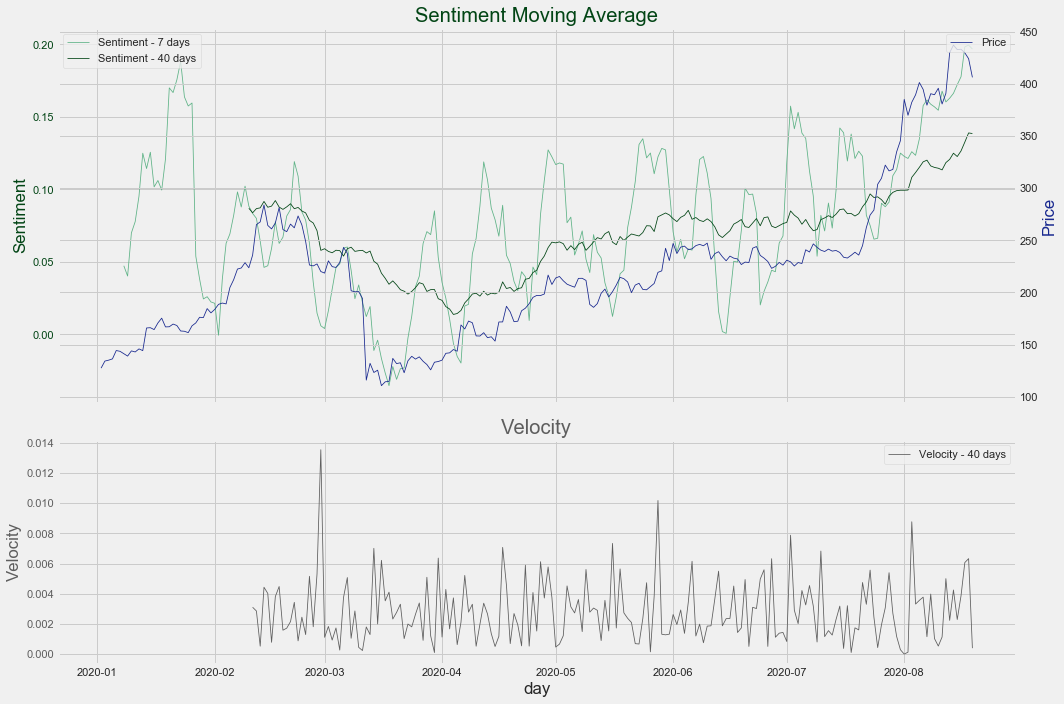

In [23]:
plot_simple_moving_average(sentiment_data, price_data=prices, twitter=True, window1=7, window2=40)

### Visualization - Weighted Moving Average

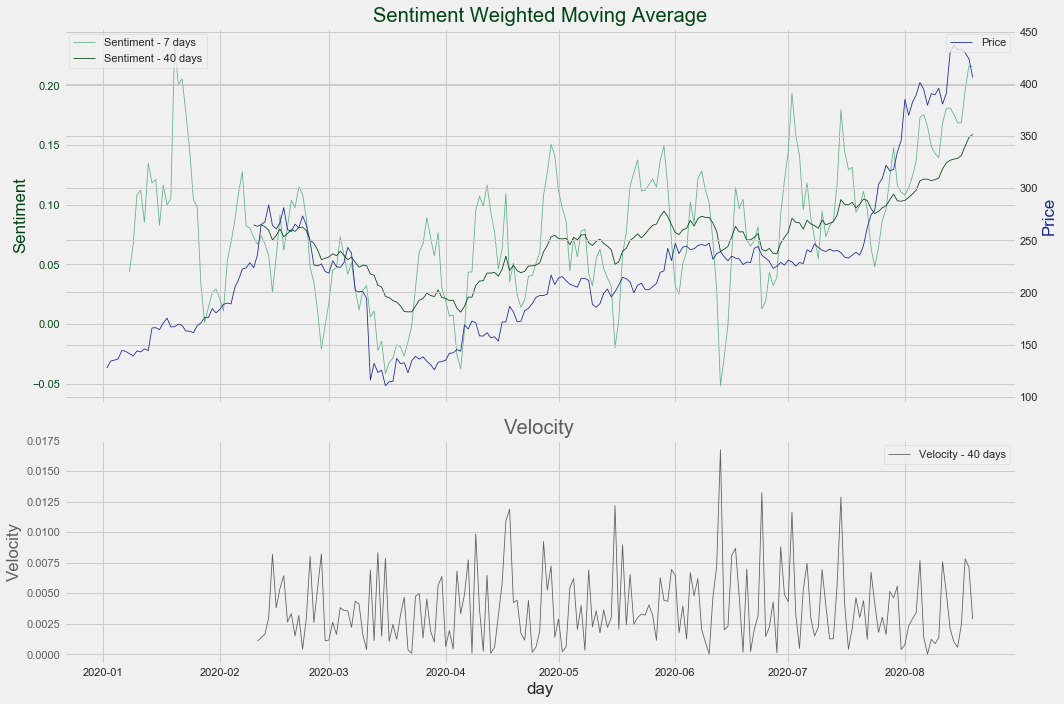

In [12]:
plot_weighted_moving_average(sentiment_data, price_data=prices, twitter=True, window1=7, window2=40)

### Visualization - Exponential Moving Average

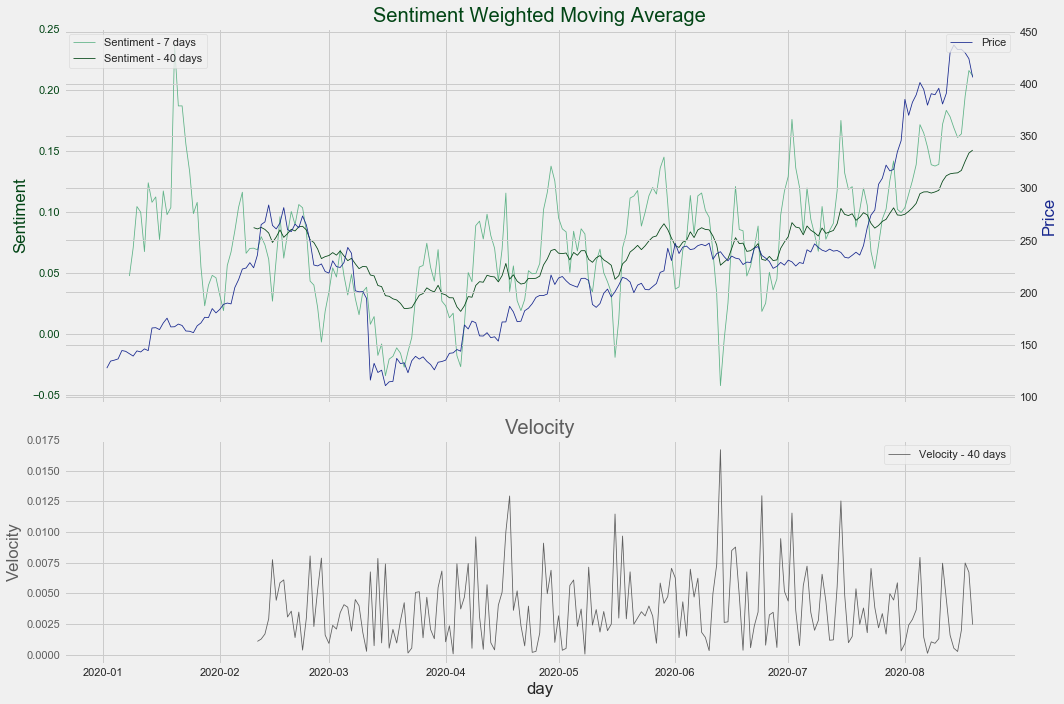

In [12]:
plot_exp_moving_average(sentiment_data, price_data=prices, twitter=True, window1=7, window2=40)